In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import numpy as np
print(np.__version__)
import deepxde as dde
print(dde.backend)
import matplotlib.pyplot as plt
from scipy import io
import pandas as pd
import time
import mat73
import os
import csv

2.1.3


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


<module 'deepxde.backend' from '/home/users/jbi/anaconda3/envs/neural_networks_anpassungen_jb/lib/python3.12/site-packages/deepxde/backend/__init__.py'>


In [2]:
# Path to training data

data = mat73.loadmat(r"/home/users/jbi/Bachelorarbeit/Codebase/Netze/MIONet/annular_P_v_IC_nl_data/annular_P_v_IC_vvar_10k_4k_20x.mat")

p_train = data["P_train"].astype(np.float32)
p_test = data["P_test"].astype(np.float32)

ic_train = data["IC_train"].astype(np.float32)
ic_test = data["IC_test"].astype(np.float32)

v_train = data["v_train"].astype(np.float32)
v_test = data["v_test"].astype(np.float32)

branch_train = np.concatenate([ic_train, v_train, p_train], axis=1)
branch_test = np.concatenate([ic_test, v_test, p_test], axis=1)

u_bias_train= data["U_bias_train"].astype(np.float32)
u_bias_test= data["U_bias_test"].astype(np.float32)
xyz_t_bias_train = data["xyz_t_bias_train"].astype(np.float32)
xyz_t_bias_test = data["xyz_t_bias_test"].astype(np.float32)

u_rd_train= data["U_rd_train"].astype(np.float32)
u_rd_test= data["U_rd_test"].astype(np.float32)
xyz_t_rd_train = data["xyz_t_rd_train"].astype(np.float32)
xyz_t_rd_test = data["xyz_t_rd_test"].astype(np.float32)

u_v_train= data["U_v_train"].astype(np.float32)
u_v_test= data["U_v_test"].astype(np.float32)
xyz_t_v_train = data["xyz_t_v_train"].astype(np.float32)
xyz_t_v_test = data["xyz_t_v_test"].astype(np.float32)

xyz_t_train = np.concatenate((xyz_t_bias_train, xyz_t_rd_train, xyz_t_v_train), axis=0)
xyz_t_test = np.concatenate((xyz_t_bias_test, xyz_t_rd_test, xyz_t_v_test), axis=0)

u_train = np.concatenate((u_bias_train, u_rd_train, u_v_train), axis=1)
u_test = np.concatenate((u_bias_test, u_rd_test, u_v_test), axis=1)

print(xyz_t_train.shape,ic_train.shape,p_train.shape,v_train.shape,branch_train.shape,u_train.shape)
print(xyz_t_test.shape,ic_test.shape,p_test.shape,v_test.shape,branch_test.shape,u_test.shape)

(6000, 4) (8000, 400) (8000, 20) (8000, 20) (8000, 440) (8000, 6000)
(6000, 4) (2000, 400) (2000, 20) (2000, 20) (2000, 440) (2000, 6000)


In [3]:
configs = []
id = 0


#n_train in (8000,800):
for neurons in (200,100,300):
    layers = 5 #for layers in (4,6):
    for act_IC in ("relu","swish"):
        for act_branch in ("relu","swish"):
                n_train = 8000
                act_trunk ="relu"# for act_trunk in ("relu","swish"):
                decay = "cosine"#for decay in ("None","cosine"):
                merge_operation = "mul" #for merge_operation in ("mul","add","cat"):
                output_merge_operation = "mul" #for merge_operation in ("mul","add","cat"):
                iterations = 100_000
                config = {
                    #"model_id": f"model_{model_id:04d}",
                    "n_train": n_train,
                    "iterations": iterations,
                    "neurons": neurons,
                    "layers": layers,
                    "activation IC": act_IC,
                    "activation Branch": act_branch,
                    "activation Trunk": act_trunk,
                    "merge_operation": merge_operation,
                    "output_merge_operation": output_merge_operation,
                    "decay": decay

                }
                configs.append(config)
                id += 1
                
print(configs[id-1])
print(id)

{'n_train': 8000, 'iterations': 100000, 'neurons': 300, 'layers': 5, 'activation IC': 'swish', 'activation Branch': 'swish', 'activation Trunk': 'relu', 'merge_operation': 'mul', 'output_merge_operation': 'mul', 'decay': 'cosine'}
12


In [4]:
i = 4
checkpoint = 100000

config = configs[i]
model_id = f"model_{i:02d}"

# Modellverzeichnis
model_dir = f"/home/users/jbi/Bachelorarbeit/Codebase/Netze/MIONet/annular_P_v_IC_nl_models/Parameterstudien_vvar/P_v_IC_lin_V2/{model_id}"
os.makedirs(model_dir, exist_ok=True)

n_train = config["n_train"]
n_test = n_train//4

y_train = u_train[:n_train]
y_test = u_test[:n_test]

x_train = (ic_train[:n_train], v_train[:n_train], p_train[:n_train], xyz_t_train)
x_test = (ic_test[:n_test], v_test[:n_test], p_test[:n_test], xyz_t_test)

data = dde.data.QuintupleCartesianProd(x_train, y_train, x_test, y_test)

# Netzwerk
x1,x2,x3,x4 = 400,20,20,4

neurons = config["neurons"]
layers = config["layers"]
act_IC = config["activation IC"]
act_branch = config["activation Branch"]
act_trunk = config["activation Trunk"]
merge_operation = config["merge_operation"]
output_merge_operation = config["output_merge_operation"]
decay = config["decay"]

if merge_operation == "cat":
    b_neurons = int(neurons/2)
else:
    b_neurons = neurons

net = dde.nn.MIONetCartesianProd_3Branches(
                    [x1] + [neurons] * (layers-1) + [b_neurons], 
                    [x2] + [neurons] * (layers-1) + [b_neurons],
                    [x3] + [neurons] * (layers-1) + [b_neurons],
                    [x4] + [neurons] * layers, 
                    {"branch1":act_IC,"branch2":act_branch,"branch3":act_branch,"trunk":act_trunk}, 
                    "Glorot normal",
                    regularization=None,
                    merge_operation=merge_operation,
                    output_merge_operation=output_merge_operation
                )

start_time = time.time()

model = dde.Model(data, net)

if decay == "cosine":
    model.compile("adam", lr=1e-3, metrics=["mean l2 relative error"],decay=("cosine", 100_000, 0))
else:
    model.compile("adam", lr=1e-3, metrics=["mean l2 relative error"])

os.makedirs(f"{model_dir}/checkpoints", exist_ok=True)
checker = dde.callbacks.ModelCheckpoint(
f"{model_dir}/checkpoints/model", save_better_only=True, period=10000
)


model.train(iterations=0)

if checkpoint == 100000:
    model.restore(f"{model_dir}/model-100000.pt")#,device="cpu")
else:
    model.restore(f"{model_dir}/checkpoints/model-{checkpoint}.pt")
    print(f"Loaded model {i} at checkpoint {checkpoint}")

Compiling model...
'compile' took 1.869420 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.65e+06]    [4.60e+06]    [1.05e+00]    

Best model at step 0:
  train loss: 4.65e+06
  test loss: 4.60e+06
  test metric: [1.05e+00]

'train' took 0.193733 s



In [5]:
# Path to validation data

data = mat73.loadmat(r"/home/users/jbi/Bachelorarbeit/Codebase/Netze/MIONet/annular_P_v_IC_nl_data/annular_P_v_IC_vvar_10k_4k_20x.mat")

p_val = data["P_val"].astype(np.float32)

ic_val = data["IC_val"].astype(np.float32)

v_val = data["v_val"].astype(np.float32)


u_val= data["U_val"].astype(np.float32)
u_val= data["U_val"].astype(np.float32)
xyz_t_val = data["xyz_t_val"].astype(np.float32)
xyz_t_val = data["xyz_t_val"].astype(np.float32)



print(xyz_t_val.shape,ic_val.shape,p_val.shape,v_val.shape,u_val.shape)

(84000, 4) (100, 400) (100, 20) (100, 20) (100, 84000)


# Analyse der Vorhersagegenauigkeit

### Visualisierung

In [6]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

# Path to output location and name

output_path = r"/home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures"
output_path += r"/annular_lin_20_"

title_add = " - Annular HS, Linear MP, max 20\% ramp"

<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_362397/1150559847.py:14: SyntaxWarning: invalid escape sequence '\%'
  title_add = " - Annular HS, Linear MP, max 20\% ramp"


Beispiel 4
Zeitpunkt 6
MAE:	 38.432034
MSE:	 4781.1274
RMSE:	 69.1457
Max E:	 944.6792 

MRE:	 0.0727137
R2:	 0.99257255
Max RE:	 1.106296
[5086.554  5086.554  5086.554  5086.554  5827.0273]
[0.01873098 0.01873098 0.01873098 0.01873098 0.02624582]


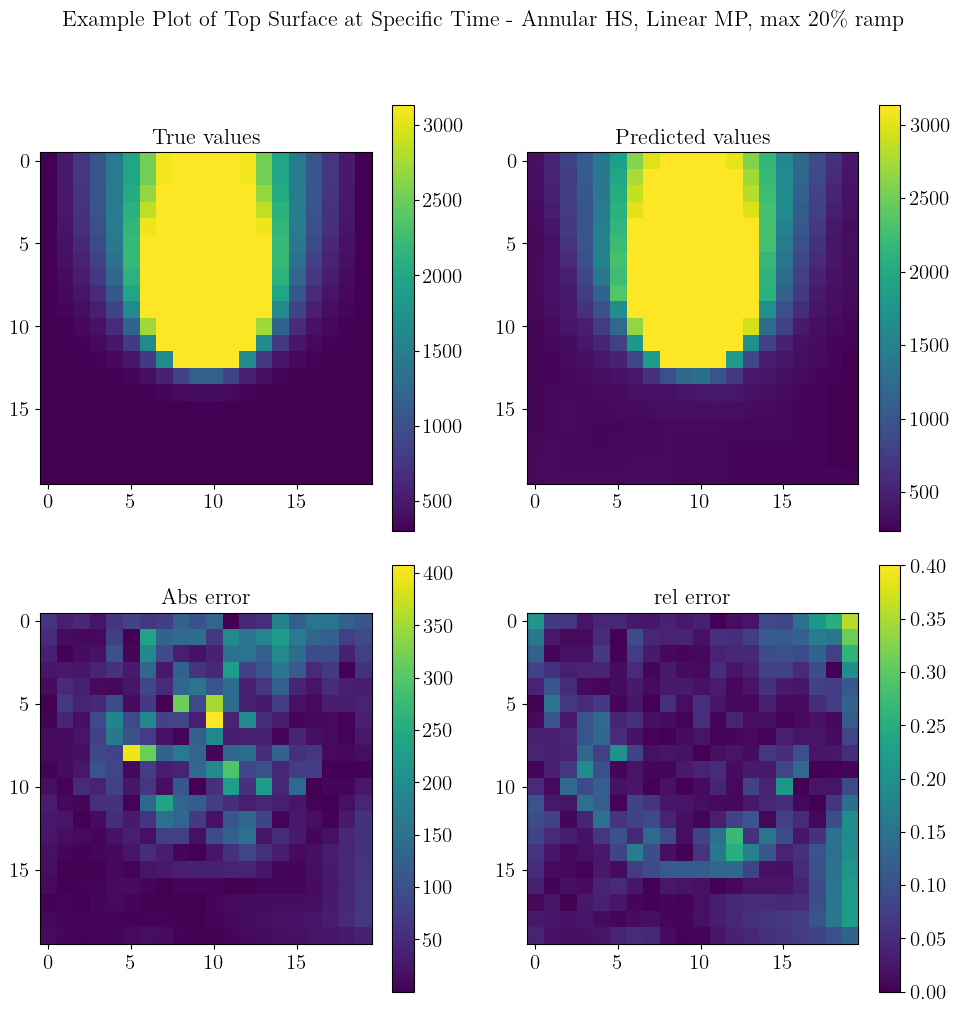

Neural network diagram saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/annular_lin_20_exampleplot.pdf


In [7]:
i = np.random.randint(0,9)
t = np.random.randint(0,20)

u_true = u_val[i]
u_true = u_true.reshape((20,20,10,21))
u_t_plot = u_true[:,:,9,t]

x_val = (ic_val[i].reshape(1, -1), v_val[i].reshape(1, -1), p_val[i].reshape(1, -1), xyz_t_val)
u_pred = model.predict(x_val)
u_pred = u_pred.reshape((20,20,10,21))
u_p_plot = u_pred[:,:,9,t]

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, median_absolute_error,
    mean_absolute_percentage_error, mean_squared_log_error,
    r2_score, max_error, explained_variance_score
)

print('Beispiel',i)
print('Zeitpunkt',t)
print('MAE:\t',np.mean(np.abs(u_true - u_pred)))
print('MSE:\t',np.mean((u_true - u_pred)**2))
print('RMSE:\t',np.sqrt(np.mean((u_true - u_pred)**2)))
print('Max E:\t',np.max(u_true - u_pred),"\n")
print('MRE:\t',np.mean(abs(u_pred-u_true)/u_true))
print('R2:\t',1 - np.sum((u_true - u_pred) ** 2) / np.sum((u_true - np.mean(u_true)) ** 2))
print('Max RE:\t',np.max(abs(u_pred-u_true)/u_true))

if t <= 1:
    print(p_val[i,:t+3])
elif t>=18:
    print(p_val[i,t-2:])
else:
    print(p_val[i,t-2:t+3])

if t <= 1:
    print(v_val[i,:t+3])
elif t>=18:
    print(v_val[i,t-2:])
else:
    print(v_val[i,t-2:t+3])

plt.rcParams.update({
    'font.size': 18,          # default text size
    'axes.titlesize': 16,     # subplot titles
    'axes.labelsize': 15,     # x and y labels
    'xtick.labelsize': 15,    # x tick labels
    'ytick.labelsize': 15,    # y tick labels
    'legend.fontsize': 15,    # legend
    'figure.titlesize': 15    # suptitle
})


fig, axs = plt.subplots(2, 2, figsize=(10,10))  # 1 Zeile, 2 Spalten

im0 = axs[0,0].imshow(u_t_plot,vmax = 3134)
axs[0,0].set_title("True values")
fig.colorbar(im0, ax=axs[0,0])

im1 = axs[0,1].imshow(u_p_plot,vmax = 3134)
axs[0,1].set_title("Predicted values")
fig.colorbar(im1, ax=axs[0,1])

im2 = axs[1,0].imshow(abs(u_p_plot-u_t_plot))
axs[1,0].set_title("Abs error")
fig.colorbar(im2, ax=axs[1,0])

im3 = axs[1,1].imshow(abs(u_p_plot-u_t_plot)/u_t_plot,vmin=0, vmax=0.4)
axs[1,1].set_title("rel error")
fig.colorbar(im3, ax=axs[1,1])

title_str = rf"Example Plot of Top Surface at Specific Time"+title_add
fig.suptitle(title_str, fontsize=16, y=1.02)

# Leave room for the suptitle
fig.tight_layout(rect=[0, 0, 1, 1])


# Save to file
save_path = output_path+r"exampleplot.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Neural network diagram saved to: {save_path}")

### Analyse

In [8]:
def metrics(u_true, u_pred):
    mae = np.mean(np.abs(u_true - u_pred))
    mse = np.mean((u_true - u_pred) ** 2)
    rmse = np.sqrt(mse)
    max_e = np.max(u_true - u_pred)
    mre = np.mean(np.abs(u_pred - u_true) / u_true)
    r2 = 1 - np.sum((u_true - u_pred) ** 2) / np.sum((u_true - np.mean(u_true)) ** 2)
    max_re = np.max(np.abs(u_pred - u_true) / u_true)
    return [mae, mse, rmse, max_e, mre, r2, max_re]

def compute_metrics_per_threshold(u_true, u_pred, thresholds):
    # Returns a dict {threshold: metric_list}
    res = {}
    for t in thresholds:
        if t is None:
            # Use all points
            res[t] = metrics(u_true, u_pred)
        else:
            mask = u_true >= t
            if np.any(mask):
                res[t] = metrics(u_true[mask], u_pred[mask])
            else:
                res[t] = [np.nan]*7
    return res

def summarize_metrics(metrics_list):
    # metrics_list: list of metric lists per example
    arr = np.array(metrics_list)  # shape (num_examples, 7)
    avg = np.nanmean(arr, axis=0)
    # Worst 10% by MAE (index 0)
    idx_sorted = np.argsort(arr[:, 0])
    worst_10pct = arr[idx_sorted[-max(1,int(len(arr)*0.1)):]]
    worst_10pct_avg = np.nanmean(worst_10pct, axis=0)
    # Single worst example (max MAE)
    worst_single = arr[idx_sorted[-1]]
    return avg, worst_10pct_avg, worst_single

def print_summary_table(thresholds, avg_metrics, worst_10pct_metrics, worst_single_metrics):
    header = ["Threshold", "MAE", "MSE", "RMSE", "Max E", "MRE", "R2", "Max RE"]
    print("{:<10} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}".format(*header))
    for t in thresholds:
        label = "All" if t is None else str(t)
        row_avg = [f"{avg_metrics[t][i]:.4f}" if not np.isnan(avg_metrics[t][i]) else "N/A" for i in range(7)]
        row_worst_10 = [f"{worst_10pct_metrics[t][i]:.4f}" if not np.isnan(worst_10pct_metrics[t][i]) else "N/A" for i in range(7)]
        row_worst_single = [f"{worst_single_metrics[t][i]:.4f}" if not np.isnan(worst_single_metrics[t][i]) else "N/A" for i in range(7)]

        print(f"Threshold {label}:")
        print("  Avg      :", " ".join(row_avg))
        print("  Worst 10%:", " ".join(row_worst_10))
        print("  Worst 1  :", " ".join(row_worst_single))
        print()

# --- Main evaluation loop ---
def evaluate_all_examples(ic_val, v_val, p_val, xyz_t_val, u_val, model, thresholds=[None,500,1000,1500]):
    all_metrics_per_threshold = {t: [] for t in thresholds}

    for i in range(len(u_val)):
        x_val = (
            ic_val[i].reshape(1, -1),
            v_val[i].reshape(1, -1),
            p_val[i].reshape(1, -1),
            xyz_t_val
        )
        u_true = np.array(u_val[i]).flatten()
        u_pred = np.array(model.predict(x_val)).flatten()

        metrics_per_t = compute_metrics_per_threshold(u_true, u_pred, thresholds)
        for t in thresholds:
            all_metrics_per_threshold[t].append(metrics_per_t[t])

    # Summarize metrics for each threshold
    avg_metrics = {}
    worst_10pct_metrics = {}
    worst_single_metrics = {}
    for t in thresholds:
        avg, worst_10pct, worst_single = summarize_metrics(all_metrics_per_threshold[t])
        avg_metrics[t] = avg
        worst_10pct_metrics[t] = worst_10pct
        worst_single_metrics[t] = worst_single

    print_summary_table(thresholds, avg_metrics, worst_10pct_metrics, worst_single_metrics)

    # Return all collected metric data for plotting
    return all_metrics_per_threshold

# --- Usage example ---
all_metrics = evaluate_all_examples(ic_val, v_val, p_val, xyz_t_val, u_val, model)

Threshold       MAE      MSE     RMSE    Max E      MRE       R2   Max RE
Threshold All:
  Avg      : 45.9739 7498.7993 82.6614 1839.7841 0.0886 0.9812 1.4391
  Worst 10%: 79.0210 16183.3516 126.7644 1611.7761 0.1477 0.9749 2.3055
  Worst 1  : 90.1654 18720.5586 136.8231 1928.6963 0.1470 0.9828 5.3573

Threshold 500:
  Avg      : 111.7119 28436.1426 162.9825 1839.7841 0.0979 0.9732 1.1298
  Worst 10%: 160.7686 58205.1016 239.9394 2124.9043 0.1361 0.9540 1.4137
  Worst 1  : 181.9441 85124.0469 291.7603 5701.5957 0.1446 0.9529 1.4830

Threshold 1000:
  Avg      : 150.3845 48101.9805 211.4071 1839.0593 0.0804 0.9621 0.8605
  Worst 10%: 225.0957 106376.1875 324.7362 3076.2542 0.1168 0.9260 0.9550
  Worst 1  : 254.7216 151839.0156 389.6653 5701.5957 0.1229 0.9381 1.0416

Threshold 1500:
  Avg      : 176.8103 65547.0938 245.6174 1839.0593 0.0713 0.9512 0.6853
  Worst 10%: 280.0226 151773.5625 387.4632 2637.3550 0.1101 0.9010 0.7555
  Worst 1  : 309.9658 218678.3750 467.6306 5701.5957 0.1099 

/tmp/ipykernel_362397/2334782235.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


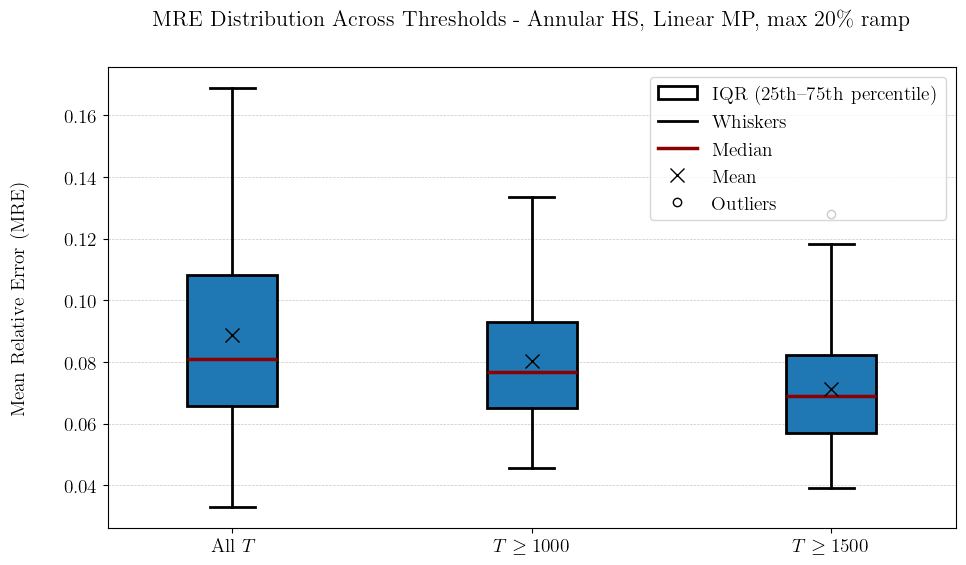

Neural network diagram saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/annular_lin_20_MRE_boxplot.pdf


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def plot_mre_boxplots(all_metrics_per_threshold, thresholds):
    # Collect MRE data
    mre_data = {}
    for t in thresholds:
        mres = [m[4] for m in all_metrics_per_threshold[t] if not np.isnan(m[4])]
        mre_data[t] = mres

    # Labels and closer positions
    labels = ["All $T$" if t is None else rf"$T \ge {t}$" for t in thresholds]
    data = [mre_data[t] for t in thresholds]
    positions = np.arange(1, len(data) + 1) * 1.2  # smaller spacing

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Boxplot styling
    boxprops = dict(linewidth=2, color='black')
    whiskerprops = dict(linewidth=2, color='black')
    capprops = dict(linewidth=2, color='black')
    medianprops = dict(linewidth=2.5, color='darkred')
    meanprops = dict(marker='x', markerfacecolor='black', markeredgecolor='black', markersize=10)

    # Draw boxplot
    ax.boxplot(
        data,
        labels=labels,
        showmeans=True,
        positions=positions,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        meanprops=meanprops,
        patch_artist=True
    )

    # Title and axis labels
    ax.set_title("MRE Distribution Across Thresholds"+title_add, fontsize=16, pad=30)
    ax.set_ylabel("Mean Relative Error (MRE)", fontsize=14, labelpad=25)
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    # Legend
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', linewidth=2, label='IQR (25th–75th percentile)'),
        Line2D([0], [0], color='black', linewidth=2, linestyle='-', label='Whiskers'),
        Line2D([0], [0], color='darkred', linewidth=2.5, linestyle='-', label='Median'),
        Line2D([0], [0], marker='x', color='black', label='Mean', markersize=10, linestyle='None'),
        Line2D([0], [0], marker='o', markerfacecolor='none',color='black', label='Outliers', markersize=6, linestyle='None'),
    ]
    ax.legend(handles=legend_elements, fontsize=14, loc='upper right', frameon=True)

    plt.tight_layout()

plt.rcParams.update({
    'font.size': 18,          # default text size
    'axes.titlesize': 16,     # subplot titles
    'axes.labelsize': 14,     # x and y labels
    'xtick.labelsize': 14,    # x tick labels
    'ytick.labelsize': 14,    # y tick labels
    'legend.fontsize': 14,    # legend
    'figure.titlesize': 14    # suptitle
})


plot_mre_boxplots(all_metrics, thresholds=[None, 1000, 1500])

# Save to file
save_path = output_path+r"MRE_boxplot.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Neural network diagram saved to: {save_path}")


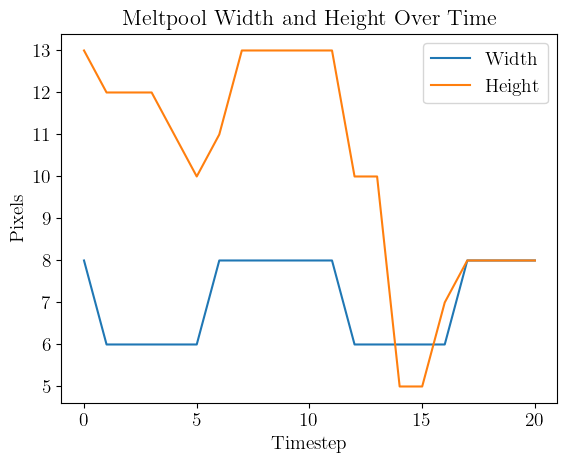

In [10]:
def compute_meltpool_extents(u_val, meltpool_threshold=0.01, depth_slice=9):
    """
    Calculates the meltpool width and height for each example and timestep.
    Returns: list of shape (num_examples, 21) with tuples (width, height)
    """
    num_examples = len(u_val)
    all_extents = []

    for i in range(num_examples):
        u = np.array(u_val[i]).reshape((20, 20, 10, 21))  # Ensure shape: (x, y, z, t)
        extents_per_t = []

        for t in range(u.shape[3]):  # 21 timesteps
            if depth_slice >= u.shape[2]:
                raise IndexError(f"depth_slice={depth_slice} is out of bounds for z-dimension with size {u.shape[2]}")

            u_slice = u[:, :, depth_slice, t]  # shape (20, 20)
            meltpool_mask = u_slice > meltpool_threshold

            if np.any(meltpool_mask):
                coords = np.argwhere(meltpool_mask)
                y_min, x_min = coords.min(axis=0)
                y_max, x_max = coords.max(axis=0)
                width = x_max - x_min + 1
                height = y_max - y_min + 1
            else:
                width = 0
                height = 0

            extents_per_t.append((width, height))

        all_extents.append(extents_per_t)

    return all_extents


meltpool_extents = compute_meltpool_extents(u_val, meltpool_threshold=1700)

# To get the max extent per example:
max_extents = [max(example_extents, key=lambda wh: wh[0]*wh[1]) for example_extents in meltpool_extents]

# To plot width and height over time for one example:
import matplotlib.pyplot as plt

example_id = 0
widths, heights = zip(*meltpool_extents[example_id])

plt.plot(widths, label='Width')
plt.plot(heights, label='Height')
plt.xlabel("Timestep")
plt.ylabel("Pixels")
plt.title("Meltpool Width and Height Over Time")
plt.legend()
plt.show()



In [11]:
import numpy as np
import matplotlib.pyplot as plt

def predict_all_u(model, ic_val, v_val, p_val, xyz_t_val):
    """
    Predicts u for all examples using the model and reshapes outputs
    to match the original u_val format: (20, 20, 10, 21)

    Parameters:
        model: trained ML model with a .predict() method
        ic_val, v_val, p_val: arrays of shape (N, features)
        xyz_t_val: common input shared across examples (e.g., spatial-temporal grid)

    Returns:
        u_pred_all: list of arrays, each shaped (20, 20, 10, 21)
    """
    u_pred_all = []
    for i in range(len(ic_val)):
        x_val = (
            ic_val[i].reshape(1, -1),
            v_val[i].reshape(1, -1),
            p_val[i].reshape(1, -1),
            xyz_t_val
        )
        u_pred = model.predict(x_val).reshape((20, 20, 10, 21))
        u_pred_all.append(u_pred)
    return u_pred_all


def compute_widths_heights(u_all, threshold=1700, z_slice=9, y_slice_for_height=9):
    num_examples = len(u_all)
    num_timesteps = 21
    widths = np.zeros((num_examples, num_timesteps))
    heights = np.zeros((num_examples, num_timesteps))

    for i in range(num_examples):
        u = np.array(u_all[i]).reshape((20, 20, 10, 21))
        for t in range(num_timesteps):
            # Width: distance along y-axis where T >= threshold at fixed z=z_slice
            slice_width = u[:, :, z_slice, t]  # shape (20,20) = (x,y)
            mask_width = slice_width >= threshold

            y_hot = np.any(mask_width, axis=0)  # axis=0 because shape (x,y)
            widths[i, t] = np.ptp(np.where(y_hot)[0]) + 1 if np.any(y_hot) else 0

            # Height: distance along z-axis where T >= threshold at fixed y=y_slice_for_height
            slice_height = u[:, y_slice_for_height, :, t]  # shape (20,10) = (x,z)
            mask_height = slice_height >= threshold

            # Collapse along x to find z indices where any x meets threshold
            z_hot = np.any(mask_height, axis=0)
            heights[i, t] = np.ptp(np.where(z_hot)[0]) + 1 if np.any(z_hot) else 0

    return widths, heights

def compute_local_widths_heights(u_all, threshold=1700, x_slice=10, y_slice=9, z_slice=9):
    """
    Computes:
      - width: along y at fixed x and z (1D slice: u[x, :, z, t])
      - height: along z at fixed x and y (1D slice: u[x, y, :, t])

    Parameters:
        u_all: list of arrays (N,) of shape (20, 20, 10, 21) when reshaped
        threshold: scalar value, meltpool threshold
        x_slice, y_slice, z_slice: indices to extract the 1D slices

    Returns:
        widths: (N, 21) array of width per timestep
        heights: (N, 21) array of height per timestep
    """
    num_examples = len(u_all)
    num_timesteps = 21
    widths = np.zeros((num_examples, num_timesteps))
    heights = np.zeros((num_examples, num_timesteps))

    for i in range(num_examples):
        u = np.array(u_all[i]).reshape((20, 20, 10, 21))
        for t in range(num_timesteps):
            # Width: y-direction at fixed x, z
            slice_w = u[x_slice, :, z_slice, t]  # shape (y,)
            hot_y = np.where(slice_w >= threshold)[0]
            widths[i, t] = np.ptp(hot_y) + 1 if len(hot_y) > 0 else 0

            # Height: z-direction at fixed x, y
            slice_h = u[x_slice, y_slice, :, t]  # shape (z,)
            hot_z = np.where(slice_h >= threshold)[0]
            heights[i, t] = np.ptp(hot_z) + 1 if len(hot_z) > 0 else 0

    return widths, heights

FMT_LATEX = r"${cnt}\times\;({pct:.1f}\,\%)$"

def annotate_repeated_outliers_with_pct(ax, outlier_dicts, totals,
                                        x_offset=0.06, y_offset_frac=0.02,
                                        color='black',
                                        fmt=r"${cnt}\times\;({pct:.1f}\,\%)$"):
    """
    y_offset_frac: vertikaler Offset in Anteil der y-Achsen-Spanne (z.B. 0.02 = 2%).
    """
    y0, y1 = ax.get_ylim()
    dy = (y1 - y0) * y_offset_frac

    for i, (freqs, total) in enumerate(zip(outlier_dicts, totals), start=1):
        if total == 0:
            continue
        for val, cnt in freqs.items():
            if cnt > 1:
                pct = 100.0 * cnt / total
                y = float(val) + dy
                # optional: oben nicht über Rand hinaus
                y = min(y, y1 - 0.01*(y1-y0))
                ax.text(i + x_offset, y,
                        fmt.format(cnt=cnt, pct=pct),
                        fontsize=12, va='bottom', ha='left', color=color)


def compute_absolute_error(true_extent, pred_extent):
    return np.abs(pred_extent - true_extent)

# Calculate predictions of all examples and timesteps
u_pred_all = predict_all_u(model, ic_val, v_val, p_val, xyz_t_val)

# Calculate widths and heights
w_true, h_true = compute_widths_heights(u_val)
w_pred, h_pred = compute_widths_heights(u_pred_all)

# Calculate absolute errors
ae_w_g = compute_absolute_error(w_true, w_pred)
ae_h_g = compute_absolute_error(h_true, h_pred)

w_true, h_true = compute_local_widths_heights(u_val)
w_pred, h_pred = compute_local_widths_heights(u_pred_all)

# Calculate absolute errors
ae_w_l = compute_absolute_error(w_true, w_pred)
ae_h_l = compute_absolute_error(h_true, h_pred)


/tmp/ipykernel_362397/1374036814.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot1 = axs[0].boxplot(global_data, labels=["Width", "Height"],
/tmp/ipykernel_362397/1374036814.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot2 = axs[1].boxplot(local_data, labels=["Width", "Height"],


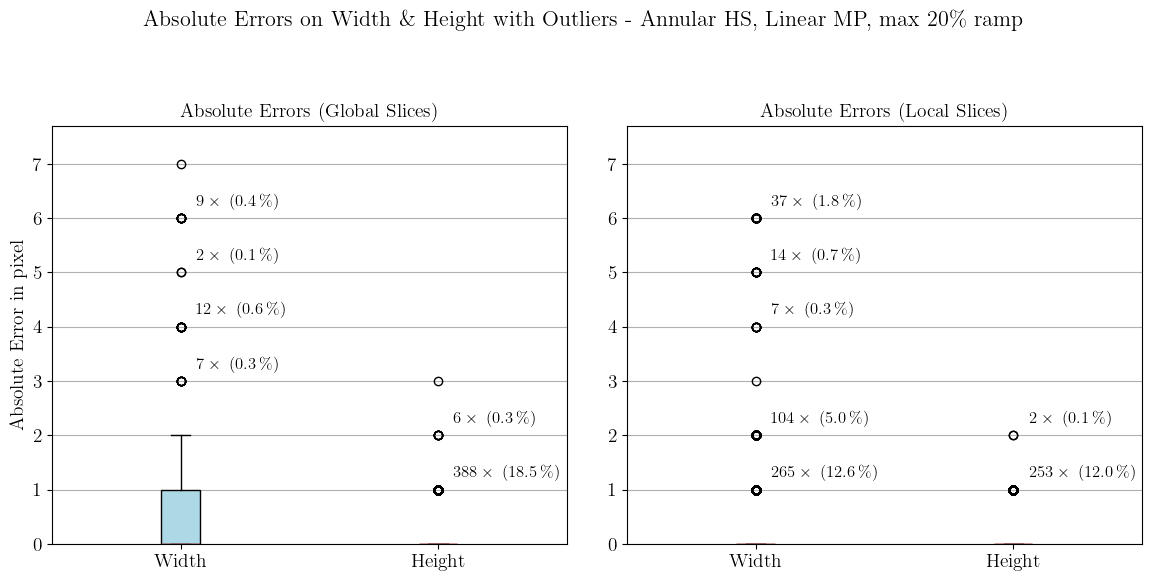

Neural network diagram saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/annular_lin_20_WH_boxplot.pdf


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_outlier_positions(data):
    """Returns a dict mapping outlier values to frequencies using IQR."""
    positions = []
    for d in data:
        d = np.array(d)
        q1 = np.percentile(d, 25)
        q3 = np.percentile(d, 75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = d[(d < lower) | (d > upper)]
        count = Counter(outliers.round(5))  # round to group close float values
        positions.append(count)
    return positions

# Prepare data
global_data = [ae_w_g.flatten(), ae_h_g.flatten()]
local_data = [ae_w_l.flatten(), ae_h_l.flatten()]
ymax = max(np.nanmax(global_data), np.nanmax(local_data)) * 1.1

# Get outlier counts
outliers_global = get_outlier_positions(global_data)
outliers_local = get_outlier_positions(local_data)

# --- totals per box (exclude NaNs) ---
totals_global = [np.count_nonzero(~np.isnan(d)) for d in global_data]
totals_local  = [np.count_nonzero(~np.isnan(d)) for d in local_data]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# --- Global Slices Plot ---
bplot1 = axs[0].boxplot(global_data, labels=["Width", "Height"],
                        patch_artist=True, showfliers=True,
                        boxprops=dict(facecolor='lightblue'),
                        medianprops=dict(color='red'))

axs[0].set_title("Absolute Errors (Global Slices)", fontsize = 14)
axs[0].set_ylabel("Absolute Error in pixel",fontsize = 14)
axs[0].set_ylim([0, ymax])
axs[0].grid(True, axis='y')


# --- Local Slices Plot ---
bplot2 = axs[1].boxplot(local_data, labels=["Width", "Height"],
                        patch_artist=True, showfliers=True,
                        boxprops=dict(facecolor='lightgreen'),
                        medianprops=dict(color='red'))

axs[1].set_title("Absolute Errors (Local Slices)",fontsize = 14)
axs[1].set_ylim([0, ymax])
axs[1].grid(True, axis='y')

# Make tick labels fontsize 14 on both axes
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=14)



# Replace your two annotation loops with:
annotate_repeated_outliers_with_pct(axs[0], outliers_global, totals_global, x_offset=0.06, y_offset_frac=0.02, color='black')
annotate_repeated_outliers_with_pct(axs[1], outliers_local,  totals_local,  x_offset=0.06, y_offset_frac=0.02, color='black')


plt.suptitle(r"Absolute Errors on Width \& Height with Outliers"+title_add, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])


# Save to file
save_path = output_path+r"WH_boxplot.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Neural network diagram saved to: {save_path}")

plt.show()


/tmp/ipykernel_362397/1536479371.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot1 = ax.boxplot(global_data, labels=["Width", "Height"],


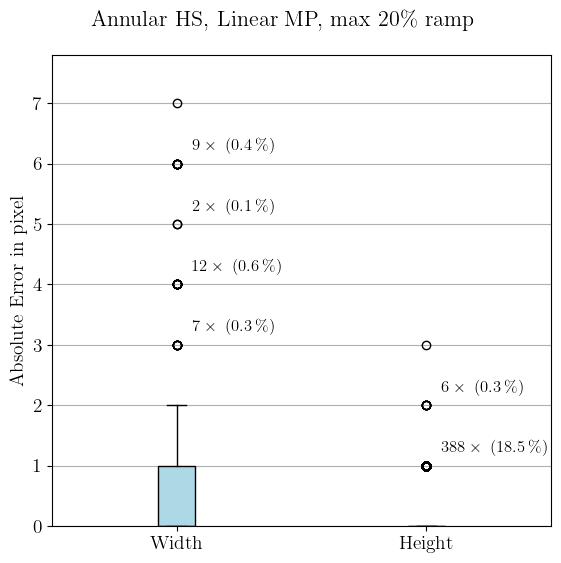

Neural network diagram saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/annular_lin_20_WH_boxplot_global.pdf


In [13]:
def annotate_all_errors_gt0(ax, outlier_dicts, totals,
                            x_offset=0.06, y_offset_frac=0.02,
                            color='black',
                            fmt=r"${cnt}\times\;({pct:.1f}\,\%)$"):
    """
    Annotates all error values > 0 (not only repeated outliers).
    Shows value count and % relative to total.
    """
    y0, y1 = ax.get_ylim()
    dy = (y1 - y0) * y_offset_frac

    for i, (freqs, total) in enumerate(zip(outlier_dicts, totals), start=1):
        if total == 0:
            continue
        for val, cnt in freqs.items():
            if val > 0:  # annotate ALL >0 values
                pct = 100.0 * cnt / total
                y = float(val) + dy
                # prevent overlap with top border
                y = min(y, y1 - 0.01*(y1-y0))
                ax.text(i + x_offset, y,
                        fmt.format(cnt=cnt, pct=pct),
                        fontsize=12, va='bottom', ha='left', color=color)


import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_outlier_positions(data):
    """Returns a dict mapping outlier values to frequencies using IQR."""
    positions = []
    for d in data:
        d = np.array(d)
        q1 = np.percentile(d, 25)
        q3 = np.percentile(d, 75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = d[(d < lower) | (d > upper)]
        count = Counter(outliers.round(5))  # round to group close float values
        positions.append(count)
    return positions

# Prepare data
global_data = [ae_w_g.flatten(), ae_h_g.flatten()]
ymax = np.nanmax(global_data) * 1.1

# Get outlier counts
outliers_global = get_outlier_positions(global_data)

# --- totals per box (exclude NaNs) ---
totals_global = [np.count_nonzero(~np.isnan(d)) for d in global_data]

# Create only one subplot
fig, ax = plt.subplots(figsize=(6, 6))

# --- Global Slices Plot ---
bplot1 = ax.boxplot(global_data, labels=["Width", "Height"],
                    patch_artist=True, showfliers=True,
                    boxprops=dict(facecolor='lightblue'),
                    medianprops=dict(color='red'))

#ax.set_title("Absolute Errors (Global Slices)", fontsize=14)
ax.set_ylabel("Absolute Error in pixel", fontsize=14)
ax.set_ylim([0, 7.8])
ax.grid(True, axis='y')

# Tick labels fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

# Annotate repeated outliers (your function should already exist)
annotate_repeated_outliers_with_pct(ax, outliers_global, totals_global,
                                    x_offset=0.06, y_offset_frac=0.02, color='black')

plt.suptitle(title_add[2:], fontsize=16, y=0.95)  # decrease y to reduce spacing
plt.tight_layout(rect=[0, 0, 1, 1])        # adjust rect so suptitle fits tighter

# Save to file
save_path = output_path + r"WH_boxplot_global.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Neural network diagram saved to: {save_path}")


<>:154: SyntaxWarning: invalid escape sequence '\%'
<>:154: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_362397/4066345342.py:154: SyntaxWarning: invalid escape sequence '\%'
  f"{count} outliers ({percent:.1f}\%)",
/tmp/ipykernel_362397/4066345342.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot_top = ax_top.boxplot(
/tmp/ipykernel_362397/4066345342.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot_bottom = ax_bottom.boxplot(
/tmp/ipykernel_362397/4066345342.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


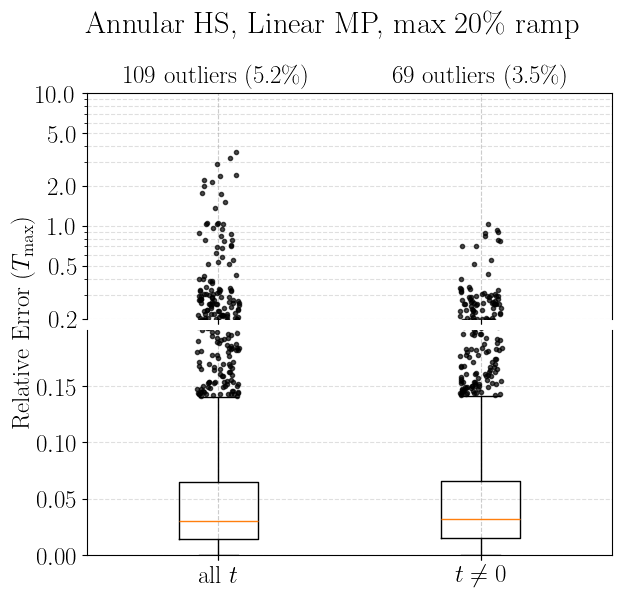

Neural network diagram saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/annular_lin_20_tmax_boxplot.pdf


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def compute_relative_error(true_val, pred_val):
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_err = np.abs(pred_val - true_val) / np.abs(true_val)
        rel_err[np.isnan(rel_err)] = 0
        rel_err[np.isinf(rel_err)] = 0
    return rel_err

def compute_tmax_global(u_all):
    num_examples = len(u_all)
    num_timesteps = 21
    t_max = np.zeros((num_examples, num_timesteps))

    for i in range(num_examples):
        u = np.array(u_all[i]).reshape((20, 20, 10, 21))
        for t in range(num_timesteps):
            t_max[i, t] = np.max(u[:, :, :, t])

    return t_max

def compute_tmax_local(u_all, x_choices=[7, 8, 9], y_avg_indices=(9, 10), z_fixed=9):
    num_examples = len(u_all)
    num_timesteps = 21
    t_max = np.zeros((num_examples, num_timesteps))

    for i in range(num_examples):
        u = np.array(u_all[i]).reshape((20, 20, 10, 21))
        for t in range(num_timesteps):
            x_vals = x_choices
            y_avg = int(np.mean(y_avg_indices))
            t_line = u[x_vals, y_avg, z_fixed, t]
            t_max[i, t] = np.max(t_line)

    return t_max

# ---------- Compute errors ----------
# Global max temp
tmax_true_global = compute_tmax_global(u_val)
tmax_pred_global = compute_tmax_global(u_pred_all)
re_global = compute_relative_error(tmax_true_global, tmax_pred_global)

# Local max temp (exclude t=0)
tmax_true_local = compute_tmax_local(u_val)
tmax_pred_local = compute_tmax_local(u_pred_all)
re_local = compute_relative_error(tmax_true_local, tmax_pred_local)
re_local_excl_t0 = re_local[:, 1:].flatten()

# ---------- Final data list for boxplotting ----------
data = [
    re_global.flatten(),
    re_local_excl_t0
]

labels = [r"all $t$", r"$t \neq 0$"]

# Outlier threshold
outlier_thresh = 0.2
outlier_mask = [d > outlier_thresh for d in data]
outlier_counts = [np.sum(mask) for mask in outlier_mask]
total_points = [len(d) for d in data]

import numpy as np

def jitter_fliers(bplot, jitter=0.05):
    """
    Apply horizontal jitter to flier markers so they don't overlap.
    bplot: return value from ax.boxplot(...)
    jitter: maximum random x-offset
    """
    
    for flier in bplot['fliers']:
        x, y = flier.get_data()
        # jitter only the x values
        x_jittered = x + np.random.uniform(-jitter, jitter, size=len(x))
        flier.set_data(x_jittered, y)

# ---------- Plot ----------
fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)

# -------- Top subplot (log scale) --------
ax_top = fig.add_subplot(gs[0])
bplot_top = ax_top.boxplot(
    data,
    labels=[""] * len(labels),
    showfliers=True,
    widths=0.3,
    flierprops=dict(
        marker='o',              # circle marker
        markersize=3,            # point size
        markerfacecolor='black', # fill color
        markeredgecolor='black', # edge color
        linestyle='none',
        alpha=0.7
    )

)
jitter_fliers(bplot_top, jitter=0.08)

ax_top.set_yscale('log')
ax_top.set_ylim(0.2, 10)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(labelbottom=False)
ax_top.set_yticks([0.2, 0.5, 1, 2, 5, 10])
ax_top.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax_top.grid(True, which='both', linestyle='--', alpha=0.4)

# -------- Bottom subplot (linear scale) --------
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
bplot_bottom = ax_bottom.boxplot(
    data,
    labels=labels,
    showfliers=True,
    widths=0.3,
    flierprops=dict(
        marker='o',              # circle marker
        markersize=3,            # point size
        markerfacecolor='black', # fill color
        markeredgecolor='black', # edge color
        linestyle='none',
        alpha=0.7
    )

)
jitter_fliers(bplot_bottom, jitter=0.08)

ax_bottom.set_ylim(0, 0.2)
ax_bottom.set_yticks(np.arange(0, 0.2, 0.05))
ax_bottom.spines['top'].set_visible(False)
ax_bottom.grid(True, linestyle='--', alpha=0.4)

# Tick label size
for ax in (ax_top, ax_bottom):
    ax.tick_params(axis='both', which='major', labelsize=18)

# Shared Y label
fig.text(0.04, 0.5, r'Relative Error ($T_{\max}$)', va='center',
         rotation='vertical', fontsize=18)



# Title
plt.suptitle(title_add[2:], fontsize=22, y=1.02)

# Outlier annotations
for i, (count, total, label) in enumerate(zip(outlier_counts, total_points, labels)):
    percent = (count / total) * 100
    ax_top.text(
        i + 1,
        11,
        f"{count} outliers ({percent:.1f}\%)",
        ha='center',
        va='bottom',
        color='black',
        fontsize=18
    )

plt.tight_layout()
plt.subplots_adjust(left=0.15)

# Save to file
save_path = output_path + r"tmax_boxplot.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Neural network diagram saved to: {save_path}")


/tmp/ipykernel_362397/1330716620.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot_top = ax_top.boxplot(data, labels=[""] * len(labels), **boxplot_style)
/tmp/ipykernel_362397/1330716620.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot_bottom = ax_bottom.boxplot(data, labels=labels, **boxplot_style)
/tmp/ipykernel_362397/1330716620.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


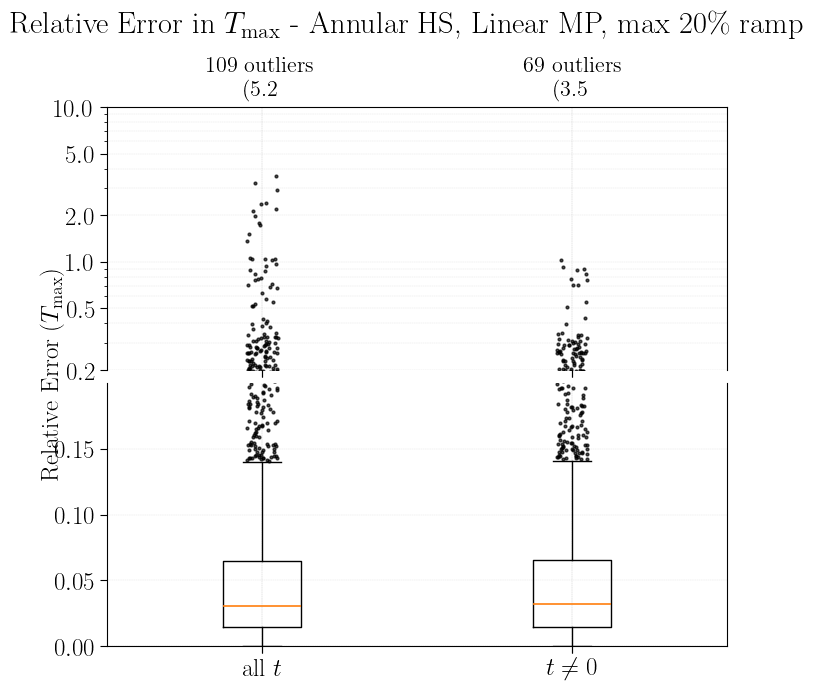

Figure saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/annular_lin_20_tmax_boxplot.pdf


In [15]:
# ---------- Plot ----------
fig = plt.figure(figsize=(8, 7))  # narrower figure (was 10,7)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)

# Common thin styles for boxplots
boxplot_style = dict(
    widths=0.25,  # was 0.4 -> narrower boxes
    showfliers=True,
    boxprops=dict(linewidth=1.0),
    whiskerprops=dict(linewidth=1.0),
    capprops=dict(linewidth=1.0),
    medianprops=dict(linewidth=1.2),
    flierprops=dict(
        marker='o',
        markersize=2.0,          # was 3 -> smaller fliers
        markerfacecolor='black',
        markeredgecolor='black',
        linestyle='none',
        alpha=0.7
    )
)

def jitter_fliers(bplot, jitter=0.05):  # was 0.08 -> a touch tighter
    for flier in bplot['fliers']:
        x, y = flier.get_data()
        if len(x):
            x_jittered = x + np.random.uniform(-jitter, jitter, size=len(x))
            flier.set_data(x_jittered, y)

# -------- Top subplot (log scale) --------
ax_top = fig.add_subplot(gs[0])
bplot_top = ax_top.boxplot(data, labels=[""] * len(labels), **boxplot_style)
jitter_fliers(bplot_top, jitter=0.05)

ax_top.set_yscale('log')
ax_top.set_ylim(0.2, 10)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(labelbottom=False, width=0.8)   # thinner ticks
ax_top.set_yticks([0.2, 0.5, 1, 2, 5, 10])
ax_top.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax_top.grid(True, which='both', linestyle='--', linewidth=0.3, alpha=0.4)  # thinner grid

# -------- Bottom subplot (linear scale) --------
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
bplot_bottom = ax_bottom.boxplot(data, labels=labels, **boxplot_style)
jitter_fliers(bplot_bottom, jitter=0.05)

ax_bottom.set_ylim(0, 0.2)
ax_bottom.set_yticks(np.arange(0, 0.2, 0.05))
ax_bottom.spines['top'].set_visible(False)
ax_bottom.grid(True, linestyle='--', linewidth=0.3, alpha=0.4)

# Make all spines thinner
for ax in (ax_top, ax_bottom):
    for sp in ax.spines.values():
        sp.set_linewidth(0.8)
    ax.tick_params(axis='both', which='major', labelsize=18, width=0.8, length=5)

# Shared Y label
fig.text(0.04, 0.5, r'Relative Error ($T_{\max}$)', va='center',
         rotation='vertical', fontsize=18)

# Title
plt.suptitle(r"Relative Error in $T_{\max}$" + title_add, fontsize=22, y=1.02)

# Outlier annotations
for i, (count, total, label) in enumerate(zip(outlier_counts, total_points, labels)):
    percent = (count / total) * 100
    ax_top.text(
        i + 1, 11,
        f"{count} outliers\n({percent:.1f}%)",
        ha='center', va='bottom', color='black', fontsize=16
    )

plt.tight_layout()

# Save to file
save_path = output_path + r"tmax_boxplot.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Figure saved to: {save_path}")


<>:126: SyntaxWarning: invalid escape sequence '\%'
<>:126: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_362397/2120120102.py:126: SyntaxWarning: invalid escape sequence '\%'
  f"{count} outliers\n({percent:.1f}\%)",
/tmp/ipykernel_362397/2120120102.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax_top.boxplot(data, labels=[""] * len(labels), showfliers=True,
/tmp/ipykernel_362397/2120120102.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax_bottom.boxplot(data, labels=labels, showfliers=True,
/tmp/ipykernel_362397/2120120102.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


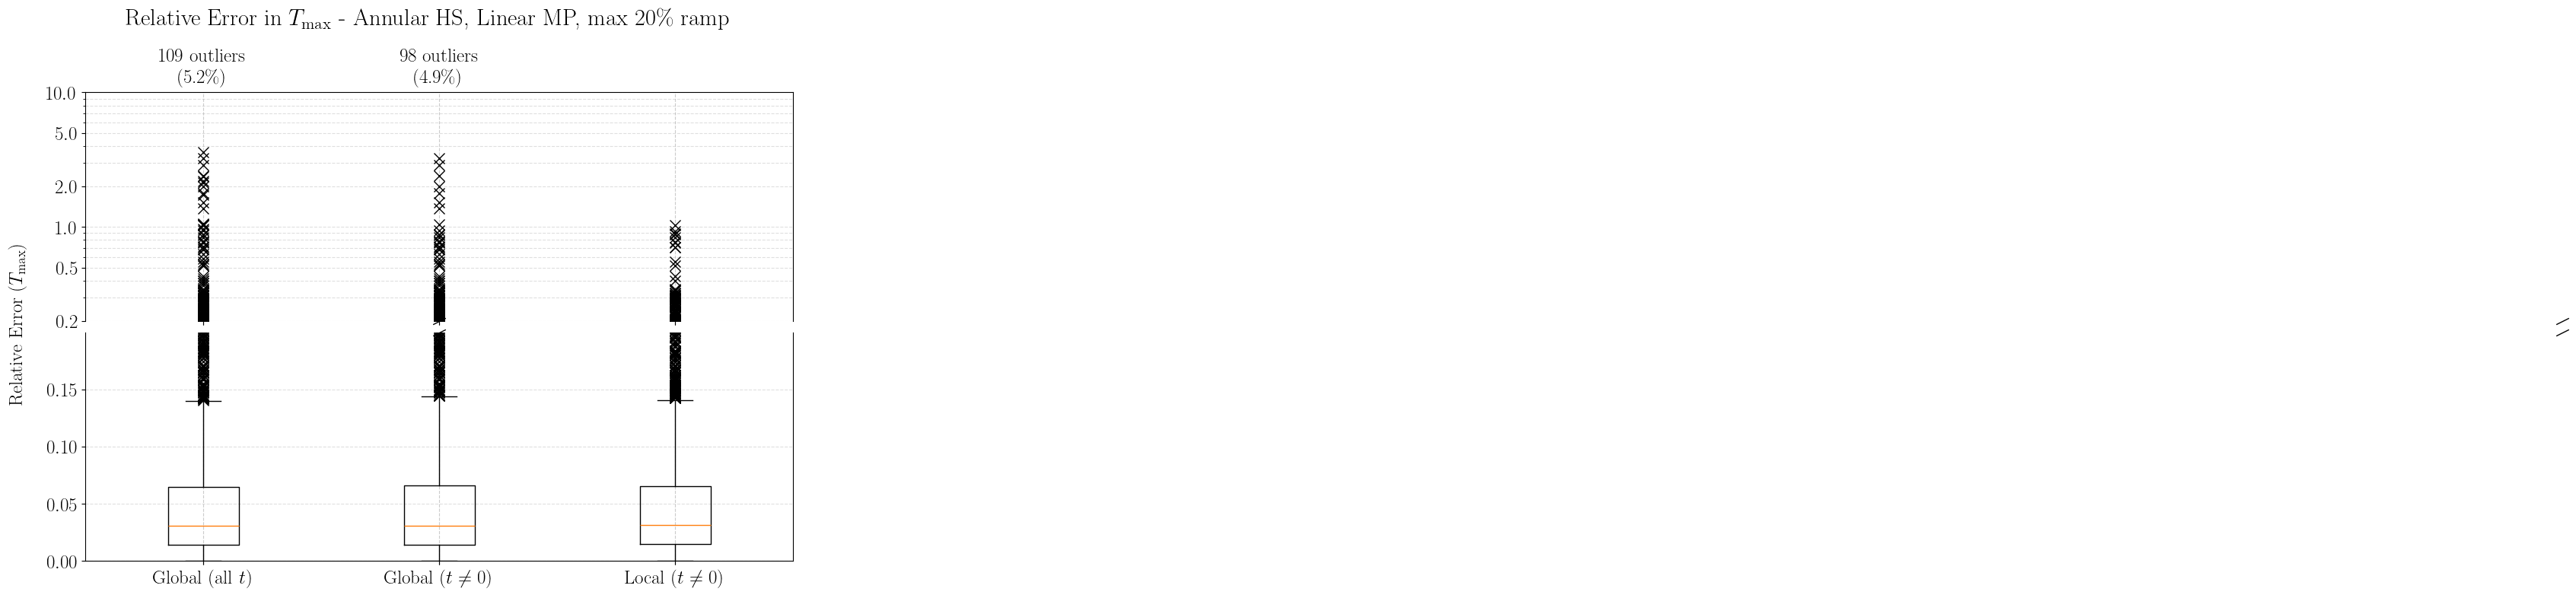

Neural network diagram saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/annular_lin_20_tmax_boxplot_old.pdf


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def compute_relative_error(true_val, pred_val):
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_err = np.abs(pred_val - true_val) / np.abs(true_val)
        rel_err[np.isnan(rel_err)] = 0
        rel_err[np.isinf(rel_err)] = 0
    return rel_err

def compute_tmax_global(u_all):
    num_examples = len(u_all)
    num_timesteps = 21
    t_max = np.zeros((num_examples, num_timesteps))

    for i in range(num_examples):
        u = np.array(u_all[i]).reshape((20, 20, 10, 21))
        for t in range(num_timesteps):
            t_max[i, t] = np.max(u[:, :, :, t])

    return t_max

def compute_tmax_local(u_all, x_choices=[7, 8, 9], y_avg_indices=(9, 10), z_fixed=9):
    num_examples = len(u_all)
    num_timesteps = 21
    t_max = np.zeros((num_examples, num_timesteps))

    for i in range(num_examples):
        u = np.array(u_all[i]).reshape((20, 20, 10, 21))
        for t in range(num_timesteps):
            x_vals = x_choices
            y_avg = int(np.mean(y_avg_indices))
            t_line = u[x_vals, y_avg, z_fixed, t]
            t_max[i, t] = np.max(t_line)

    return t_max

# Global max temp
tmax_true_global = compute_tmax_global(u_val)
tmax_pred_global = compute_tmax_global(u_pred_all)
re_global = compute_relative_error(tmax_true_global, tmax_pred_global)

# Exclude t = 0
re_global_excl_t0 = re_global[:, 1:].flatten()

# Local max temp (along T[x, avg_y, z=9, t] for x in [7,8,9])
tmax_true_local = compute_tmax_local(u_val)
tmax_pred_local = compute_tmax_local(u_pred_all)
re_local = compute_relative_error(tmax_true_local, tmax_pred_local)
re_local_excl_t0 = re_local[:, 1:].flatten()

# Final data list for boxplotting
data = [
    re_global.flatten(),
    re_global_excl_t0,
    re_local_excl_t0
]

labels = [r"Global (all $t$)", r"Global ($t \neq 0$)", r"Local ($t \neq 0$)"]
# Outlier threshold
outlier_thresh = 0.2
outlier_mask = [d > outlier_thresh for d in data]
outlier_counts = [np.sum(mask) for mask in outlier_mask]

# Create figure
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)

# ... dein Code bis inkl. Erstellung der Achsen ...

# -------- Top subplot (log scale) --------
ax_top = fig.add_subplot(gs[0])
ax_top.boxplot(data, labels=[""] * len(labels), showfliers=True,
               flierprops=dict(marker='x', markerfacecolor='none', markersize=10, linestyle='none'))
ax_top.set_yscale('log')
ax_top.set_ylim(0.2, 10)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(labelbottom=False)
ax_top.set_yticks([0.2, 0.5, 1, 2, 5, 10])
ax_top.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax_top.grid(True, which='both', linestyle='--', alpha=0.4)



# -------- Bottom subplot (linear scale) --------
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
ax_bottom.boxplot(data, labels=labels, showfliers=True,
                  flierprops=dict(marker='x', markerfacecolor='none', markersize=10, linestyle='none'))
ax_bottom.set_ylim(0, 0.2)
ax_bottom.set_yticks(np.arange(0, 0.2, 0.05))
ax_bottom.spines['top'].set_visible(False)
ax_bottom.grid(True, linestyle='--', alpha=0.4)

# >>> Einheitliche Tick-Label-Größe 18
for ax in (ax_top, ax_bottom):
    ax.tick_params(axis='both', which='major', labelsize=18)

# >>> X-Tick-Labels der Boxplots auf 18 (falls tick_params nicht greift)
for ax in (ax_top, ax_bottom):
    ax.tick_params(axis='both', which='major', labelsize=18)


# -------- Shared Y label --------
# >>> LaTeX-sicher und Größe 18
fig.text(0.04, 0.5, r'Relative Error ($T_{\max}$)', va='center', rotation='vertical', fontsize=18)

# -------- Break markers --------
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax_top.plot([0.5, len(labels) + 0.5], [0, 0], transform=ax_top.transAxes, **kwargs)
ax_bottom.plot([0.5, len(labels) + 0.5], [1, 1], transform=ax_bottom.transAxes, **kwargs)

# -------- Titel --------
# >>> Titelgröße 20
plt.suptitle(r"Relative Error in $T_{\max}$" + title_add, fontsize=22, y=1.02)

# >>> Outlier-Annotationen auf Größe 18 anpassen
# (vorher: fontsize=11)
for i, (count, total, label) in enumerate(zip(outlier_counts, total_points, labels)):
    percent = (count / total) * 100
    ax_top.text(
        i + 1,
        11,
        f"{count} outliers\n({percent:.1f}\%)",
        ha='center',
        va='bottom',
        color='black',
        fontsize=18   # <<<<<<<<<<<<<<
    )

plt.tight_layout()



# Save to file
save_path = output_path+r"tmax_boxplot_old.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Neural network diagram saved to: {save_path}")




Aggregated over all samples & timesteps:
MAE:	45.9738
MSE:	7498.79
RMSE:	86.5956
Max E:	7601.61
MRE:	0.0886312
R2:	0.98197
Max RE:	5.35733


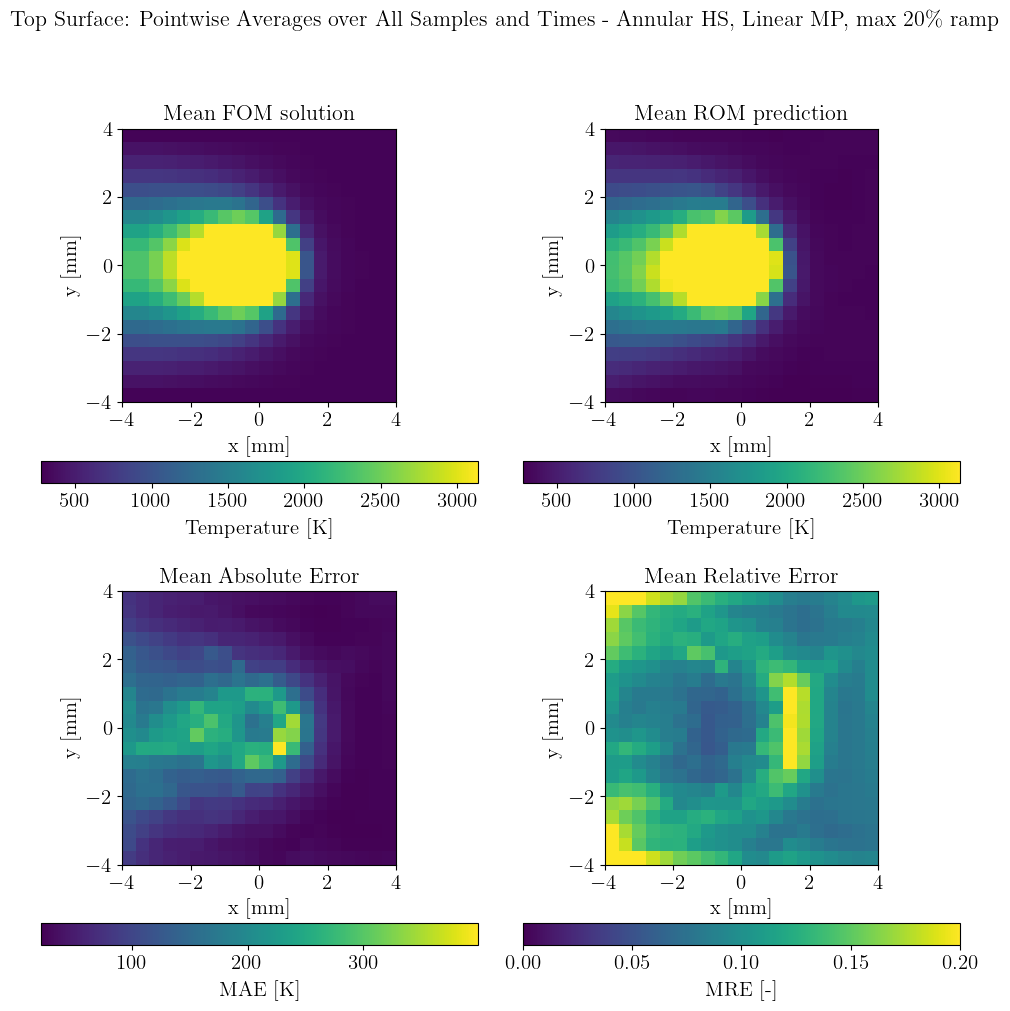

Figure saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/annular_lin_20_average_plot.pdf


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Get predictions for all samples if not already available ---
try:
    U_pred_list = u_pred_all  # from your earlier predict_all_u(...)
except NameError:
    # Fallback: compute now
    U_pred_list = predict_all_u(model, ic_val, v_val, p_val, xyz_t_val)

# --- Shape to (N, 20, 20, 10, 21) ---
U_true = np.asarray(u_val)
if U_true.ndim == 2 and U_true.shape[1] == 20*20*10*21:
    U_true = U_true.reshape((-1, 20, 20, 10, 21))
else:
    U_true = np.stack([np.asarray(x).reshape(20,20,10,21) for x in u_val], axis=0)

U_pred = np.asarray(U_pred_list)  # (N, 20, 20, 10, 21)
assert U_pred.shape == U_true.shape, f"Shape mismatch: {U_pred.shape} vs {U_true.shape}"

# --- Average across samples and time (axis 0 and 4) on the top surface (z=9) ---
z_idx = 9
true_plane_all = U_true[:, :, :, z_idx, :]  # (N, 20, 20, 21)
pred_plane_all = U_pred[:, :, :, z_idx, :]  # (N, 20, 20, 21)

true_mean = np.nanmean(true_plane_all, axis=(0, 3))  # (20, 20)
pred_mean = np.nanmean(pred_plane_all, axis=(0, 3))  # (20, 20)

# Mean absolute error map across samples & time
mae_map = np.nanmean(np.abs(pred_plane_all - true_plane_all), axis=(0, 3))  # (20, 20)

# Mean relative error map across samples & time (safe division)
with np.errstate(divide='ignore', invalid='ignore'):
    rel_all = np.abs(pred_plane_all - true_plane_all) / np.where(np.abs(true_plane_all) > 0,
                                                                 np.abs(true_plane_all), np.nan)
rel_map = np.nanmean(rel_all, axis=(0, 3))  # (20, 20)

# --- Global (all elements) metrics aggregated over N,x,y,z,t ---
D = U_pred - U_true
mae  = float(np.mean(np.abs(D)))
mse  = float(np.mean(D**2))
rmse = float(np.sqrt(mse))
max_e = float(np.max(U_true - U_pred))  # consistent with your 'Max E' sign
with np.errstate(divide='ignore', invalid='ignore'):
    mre = float(np.nanmean(np.abs(D) / np.where(np.abs(U_true)>0, np.abs(U_true), np.nan)))
    max_re = float(np.nanmax(np.abs(D) / np.where(np.abs(U_true)>0, np.abs(U_true), np.nan)))
r2 = float(1 - np.sum(D**2) / np.sum((U_true - np.mean(U_true))**2))

print("Aggregated over all samples & timesteps:")
print(f"MAE:\t{mae:.6g}")
print(f"MSE:\t{mse:.6g}")
print(f"RMSE:\t{rmse:.6g}")
print(f"Max E:\t{max_e:.6g}")
print(f"MRE:\t{mre:.6g}")
print(f"R2:\t{r2:.6g}")
print(f"Max RE:\t{max_re:.6g}")


plt.rcParams.update({
    'font.size': 18,          # default text size
    'axes.titlesize': 16,     # subplot titles
    'axes.labelsize': 15,     # x and y labels
    'xtick.labelsize': 15,    # x tick labels
    'ytick.labelsize': 15,    # y tick labels
    'legend.fontsize': 15,    # legend
    'figure.titlesize': 15    # suptitle
})

# --- Plot like your example, but with the averaged maps ---
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Use a common scale for the first two panels
vmin = min(np.nanmin(true_mean), np.nanmin(pred_mean))
vmax = 3134  # or max(np.nanmax(true_mean), np.nanmax(pred_mean))

# Helper: set axis labels and range
def format_axis(ax):
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")

# Rotate data by 90 degrees
true_rot = np.rot90(true_mean)
pred_rot = np.rot90(pred_mean)
mae_rot  = np.rot90(mae_map)
rel_rot  = np.rot90(rel_map)

im0 = axs[0, 0].imshow(true_rot, vmin=vmin, vmax=vmax,
                       extent=[-4, 4, -4, 4], origin="lower")
axs[0, 0].set_title("Mean FOM solution")
cbar0 = fig.colorbar(im0, ax=axs[0, 0], orientation="horizontal")
cbar0.set_label("Temperature [K]", labelpad=5)   # <-- beneath legend
format_axis(axs[0, 0])

im1 = axs[0, 1].imshow(pred_rot, vmin=vmin, vmax=vmax,
                       extent=[-4, 4, -4, 4], origin="lower")
axs[0, 1].set_title("Mean ROM prediction")
cbar1 = fig.colorbar(im1, ax=axs[0, 1], orientation="horizontal")
cbar1.set_label("Temperature [K]", labelpad=5)
format_axis(axs[0, 1])

im2 = axs[1, 0].imshow(mae_rot, extent=[-4, 4, -4, 4], origin="lower")
axs[1, 0].set_title("Mean Absolute Error")
cbar2 = fig.colorbar(im2, ax=axs[1, 0], orientation="horizontal")
cbar2.set_label("MAE [K]", labelpad=5)
format_axis(axs[1, 0])

im3 = axs[1, 1].imshow(rel_rot, vmin=0, vmax=0.2,
                       extent=[-4, 4, -4, 4], origin="lower")
axs[1, 1].set_title("Mean Relative Error")
cbar3 = fig.colorbar(im3, ax=axs[1, 1], orientation="horizontal")
cbar3.set_label("MRE [-]", labelpad=5)
format_axis(axs[1, 1])

# Title (append your optional title_add if you have it)
try:
    title_extra = title_add
except NameError:
    title_extra = ""
title_str = rf"Top Surface: Pointwise Averages over All Samples and Times{title_extra}"
fig.suptitle(title_str, fontsize=16, y=1.02)

# Leave room for suptitle; save before show
fig.tight_layout(rect=[0, 0, 1, 1])

# Save to file
save_path = output_path + r"average_plot.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Figure saved to: {save_path}")


Found 10 candidate(s) with u_true == 300 on the slice (z=9, t=0).
Worst example by MaxRE: i=51, MaxRE=3.609513, MRE=0.331293
Worst pixel at (row, col) = (np.int64(0), np.int64(11)), rel_err=3.609513


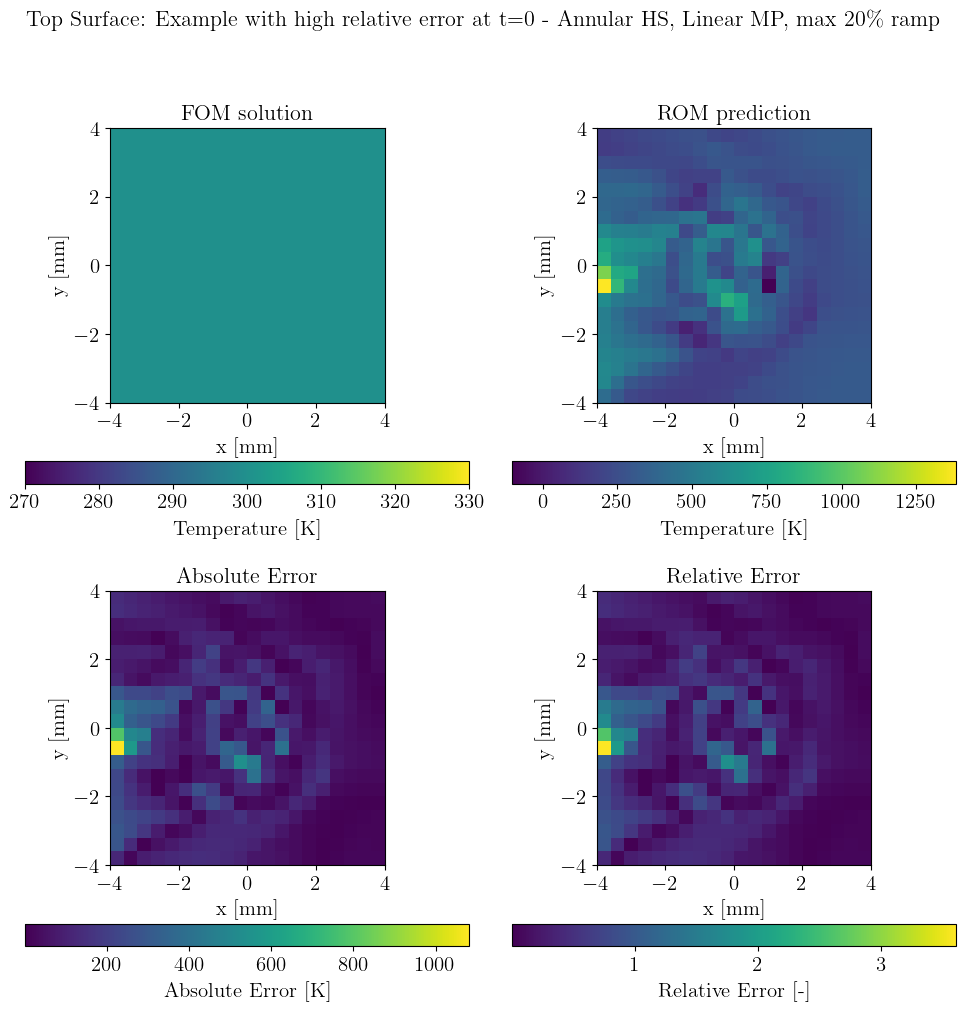

Neural network diagram saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/annular_lin_20_exampleplot_t0_worst_300.pdf


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# --- CONFIG ---
t = 0          # time index to evaluate
z_idx = 9      # slice index along z
atol_300 = 1e-6  # tolerance for checking u_true == 300 everywhere

def safe_rel_err(pred, true):
    with np.errstate(divide='ignore', invalid='ignore'):
        rel = np.abs(pred - true) / np.abs(true)
        rel[np.isnan(rel)] = 0
        rel[np.isinf(rel)] = 0
    return rel

def predict_one(i):
    x_val = (
        ic_val[i].reshape(1, -1),
        v_val[i].reshape(1, -1),
        p_val[i].reshape(1, -1),
        xyz_t_val
    )
    up = model.predict(x_val).reshape((20, 20, 10, 21))
    return up

def slice_top_surface(u4d, z=z_idx, t_ind=t):
    return u4d[:, :, z, t_ind]

# ---- scan all examples; keep only ones with u_true == 300 everywhere on the slice ----
num_examples = len(u_val)
candidates = []

for i in range(num_examples):
    u_true_4d = u_val[i].reshape((20, 20, 10, 21))
    true_slice = slice_top_surface(u_true_4d, z_idx, t)

    # keep only if the slice is 300 at all points (within tolerance)
    if np.allclose(true_slice, 300.0, atol=atol_300, rtol=0.0):
        u_pred_4d = predict_one(i)
        pred_slice = slice_top_surface(u_pred_4d, z_idx, t)

        rel_map = safe_rel_err(pred_slice, true_slice)
        maxre = float(np.max(rel_map))
        mre = float(np.mean(rel_map))

        candidates.append({
            "i": i,
            "true_slice": true_slice,
            "pred_slice": pred_slice,
            "rel_map": rel_map,
            "maxre": maxre,
            "mre": mre
        })

print(f"Found {len(candidates)} candidate(s) with u_true == 300 on the slice (z={z_idx}, t={t}).")

if not candidates:
    print("No examples satisfied u_true == 300 everywhere on the chosen slice. "
          "Consider relaxing 'atol_300' or checking a different (z, t).")
else:
    # ---- pick the worst by MAX local relative error ----
    worst = max(candidates, key=lambda s: s["maxre"])
    i_worst = worst["i"]
    true_slice = worst["true_slice"]
    pred_slice = worst["pred_slice"]
    rel_map = worst["rel_map"]

    # location of worst pixel
    worst_idx = np.unravel_index(np.argmax(rel_map), rel_map.shape)

    print(f"Worst example by MaxRE: i={i_worst}, MaxRE={worst['maxre']:.6f}, MRE={worst['mre']:.6f}")
    print(f"Worst pixel at (row, col) = {worst_idx}, rel_err={rel_map[worst_idx]:.6f}")

    # ---- plot like your original 2x2 layout ----
    plt.rcParams.update({
        'font.size': 18,
        'axes.titlesize': 16,
        'axes.labelsize': 15,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 15,
        'figure.titlesize': 15
    })

    # --- Plot like your example, but with the averaged maps ---
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Use a common scale for the first two panels
    vmin = min(np.nanmin(true_mean), np.nanmin(pred_mean))
    vmax = 3134  # or max(np.nanmax(true_mean), np.nanmax(pred_mean))

    # Helper: set axis labels and range
    def format_axis(ax):
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("y [mm]")

    # Rotate data by 90 degrees
    true_rot = np.rot90(true_slice)
    pred_rot = np.rot90(pred_slice)
    mae_rot  = np.rot90(abs(pred_slice-true_slice))
    rel_rot  = np.rot90(rel_map)

    im0 = axs[0, 0].imshow(true_rot,
                        extent=[-4, 4, -4, 4], origin="lower")
    axs[0, 0].set_title("FOM solution")
    cbar0 = fig.colorbar(im0, ax=axs[0, 0], orientation="horizontal")
    cbar0.set_label("Temperature [K]", labelpad=5)   # <-- beneath legend
    format_axis(axs[0, 0])

    im1 = axs[0, 1].imshow(pred_rot,
                        extent=[-4, 4, -4, 4], origin="lower")
    axs[0, 1].set_title("ROM prediction")
    cbar1 = fig.colorbar(im1, ax=axs[0, 1], orientation="horizontal")
    cbar1.set_label("Temperature [K]", labelpad=5)
    format_axis(axs[0, 1])

    im2 = axs[1, 0].imshow(mae_rot, extent=[-4, 4, -4, 4], origin="lower")
    axs[1, 0].set_title("Absolute Error")
    cbar2 = fig.colorbar(im2, ax=axs[1, 0], orientation="horizontal")
    cbar2.set_label("Absolute Error [K]", labelpad=5)
    format_axis(axs[1, 0])

    im3 = axs[1, 1].imshow(rel_rot, 
                        extent=[-4, 4, -4, 4], origin="lower")
    axs[1, 1].set_title("Relative Error")
    cbar3 = fig.colorbar(im3, ax=axs[1, 1], orientation="horizontal")
    cbar3.set_label("Relative Error [-]", labelpad=5)
    format_axis(axs[1, 1])

    title_str = (rf"Top Surface: Example with high relative error at t=0") + title_add
    fig.suptitle(title_str, fontsize=16, y=1.02)

    fig.suptitle(title_str, fontsize=16, y=1.02)

    fig.tight_layout(rect=[0, 0, 1, 1])

    # Leave room for suptitle; save before show
    fig.tight_layout(rect=[0, 0, 1, 1])

    # save
    save_path = output_path + rf"exampleplot_t{t}_worst_300.pdf"
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print(f"Neural network diagram saved to: {save_path}")


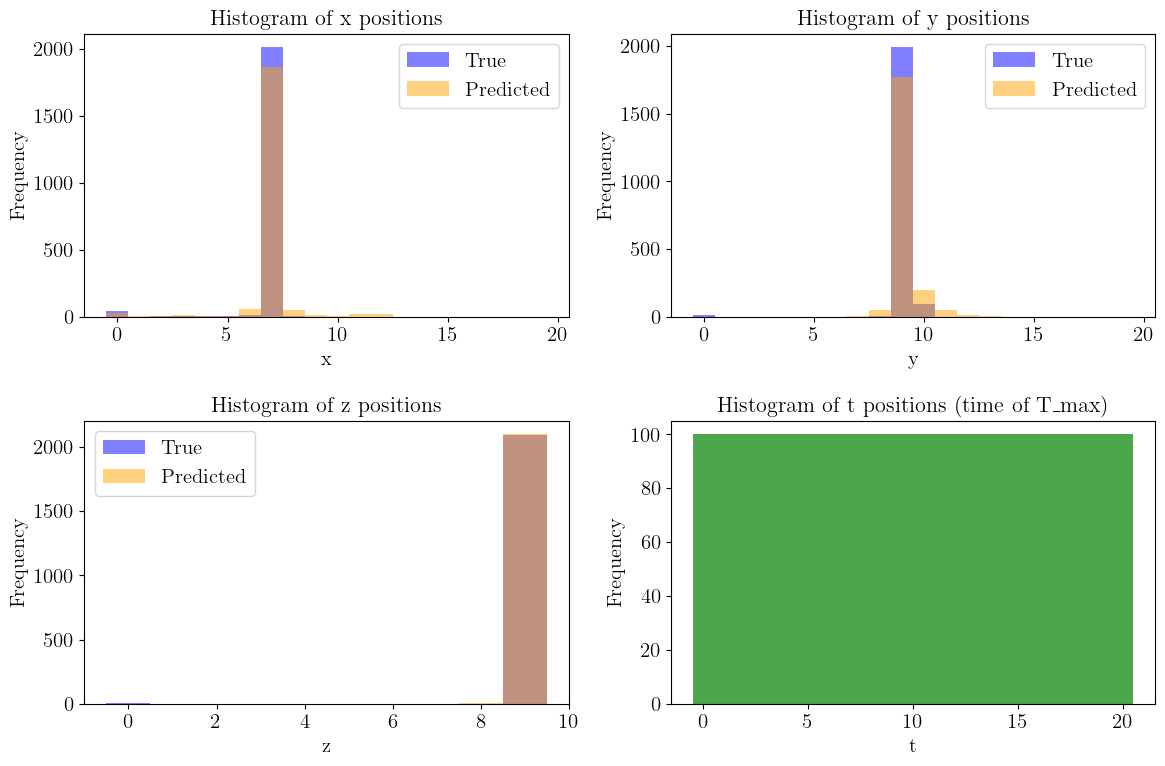

In [19]:
def get_tmax_positions(u_true_all, u_pred_all):
    """
    Computes the max temperature and its spatial positions (x, y, z) over time
    for both true and predicted data.

    Parameters:
        u_true_all: list or array of shape (N,), each element shape (20,20,10,21)
        u_pred_all: same shape as u_true_all

    Returns:
        pos_true: ndarray of shape (N, 21, 3) for true max T positions
        pos_pred: ndarray of shape (N, 21, 3) for predicted max T positions
        t_max_true: ndarray of shape (N, 21)
        t_max_pred: ndarray of shape (N, 21)
    """
    num_examples = len(u_true_all)
    num_timesteps = 21

    pos_true = np.zeros((num_examples, num_timesteps, 3), dtype=int)
    pos_pred = np.zeros((num_examples, num_timesteps, 3), dtype=int)
    t_max_true = np.zeros((num_examples, num_timesteps))
    t_max_pred = np.zeros((num_examples, num_timesteps))

    for i in range(num_examples):
        u_true = np.array(u_true_all[i]).reshape((20, 20, 10, 21))
        u_pred = np.array(u_pred_all[i]).reshape((20, 20, 10, 21))
        for t in range(num_timesteps):
            u_t_true = u_true[:, :, :, t]
            u_t_pred = u_pred[:, :, :, t]

            t_max_true[i, t] = u_t_true.max()
            t_max_pred[i, t] = u_t_pred.max()

            pos_true[i, t] = np.unravel_index(np.argmax(u_t_true), u_t_true.shape)
            pos_pred[i, t] = np.unravel_index(np.argmax(u_t_pred), u_t_pred.shape)

    return pos_true, pos_pred, t_max_true, t_max_pred

pos_true, pos_pred, t_max_true, t_max_pred = get_tmax_positions(u_val, u_pred_all)

# Flatten all positions into arrays for histogram plotting
x_true = pos_true[:, :, 0].flatten()
y_true = pos_true[:, :, 1].flatten()
z_true = pos_true[:, :, 2].flatten()
t_vals = np.tile(np.arange(21), len(pos_true))  # Repeat t = 0 to 20 for each example

x_pred = pos_pred[:, :, 0].flatten()
y_pred = pos_pred[:, :, 1].flatten()
z_pred = pos_pred[:, :, 2].flatten()

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# X position
axs[0, 0].hist(x_true, bins=np.arange(21)-0.5, alpha=0.5, label='True', color='blue')
axs[0, 0].hist(x_pred, bins=np.arange(21)-0.5, alpha=0.5, label='Predicted', color='orange')
axs[0, 0].set_title("Histogram of x positions")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].legend()

# Y position
axs[0, 1].hist(y_true, bins=np.arange(21)-0.5, alpha=0.5, label='True', color='blue')
axs[0, 1].hist(y_pred, bins=np.arange(21)-0.5, alpha=0.5, label='Predicted', color='orange')
axs[0, 1].set_title("Histogram of y positions")
axs[0, 1].set_xlabel("y")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].legend()

# Z position
axs[1, 0].hist(z_true, bins=np.arange(11)-0.5, alpha=0.5, label='True', color='blue')
axs[1, 0].hist(z_pred, bins=np.arange(11)-0.5, alpha=0.5, label='Predicted', color='orange')
axs[1, 0].set_title("Histogram of z positions")
axs[1, 0].set_xlabel("z")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].legend()

# T position (same for both, but over error)
axs[1, 1].hist(t_vals, bins=np.arange(22)-0.5, alpha=0.7, color='green')
axs[1, 1].set_title("Histogram of t positions (time of T_max)")
axs[1, 1].set_xlabel("t")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


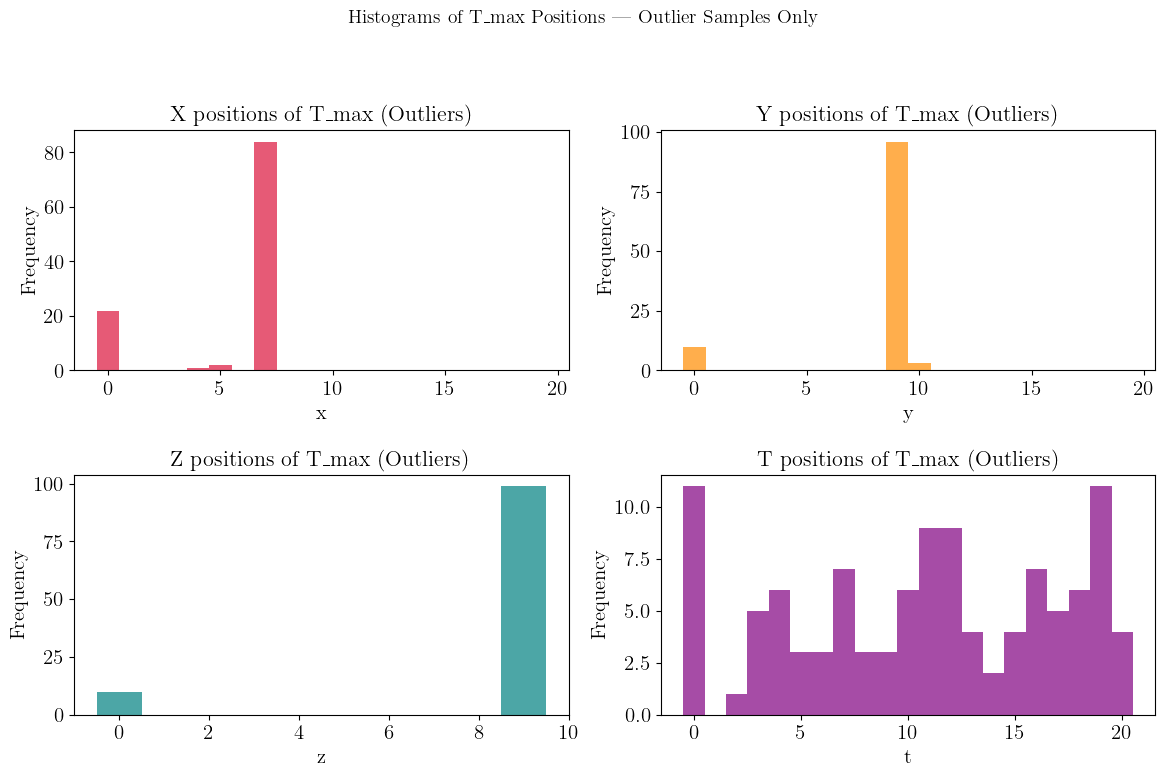

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Define a threshold for what counts as an outlier in relative T_max error
outlier_thresh = 0.2  # adjust this as needed

# Boolean mask of outlier positions
outlier_mask = re_global > outlier_thresh

# Get indices of outlier positions
outlier_indices = np.argwhere(outlier_mask)  # shape: (num_outliers, 2), with (i, t)

# Extract positions of T_max for outliers
x_out = []
y_out = []
z_out = []
t_out = []

for i, t in outlier_indices:
    x_out.append(pos_true[i, t, 0])
    y_out.append(pos_true[i, t, 1])
    z_out.append(pos_true[i, t, 2])
    t_out.append(t)

x_out = np.array(x_out)
y_out = np.array(y_out)
z_out = np.array(z_out)
t_out = np.array(t_out)

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# X
axs[0, 0].hist(x_out, bins=np.arange(21)-0.5, color='crimson', alpha=0.7)
axs[0, 0].set_title("X positions of T_max (Outliers)")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("Frequency")

# Y
axs[0, 1].hist(y_out, bins=np.arange(21)-0.5, color='darkorange', alpha=0.7)
axs[0, 1].set_title("Y positions of T_max (Outliers)")
axs[0, 1].set_xlabel("y")
axs[0, 1].set_ylabel("Frequency")

# Z
axs[1, 0].hist(z_out, bins=np.arange(11)-0.5, color='teal', alpha=0.7)
axs[1, 0].set_title("Z positions of T_max (Outliers)")
axs[1, 0].set_xlabel("z")
axs[1, 0].set_ylabel("Frequency")

# T
axs[1, 1].hist(t_out, bins=np.arange(22)-0.5, color='purple', alpha=0.7)
axs[1, 1].set_title("T positions of T_max (Outliers)")
axs[1, 1].set_xlabel("t")
axs[1, 1].set_ylabel("Frequency")

plt.suptitle("Histograms of T_max Positions — Outlier Samples Only", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
